# 1. Exploração dos dados

## 1.1. Criação de um DataFrame a partir do dataset

### Inicialmente, vamos apenas importar o JSON fornecido para gerar um DataFrame e ter uma visualização inicial dos dados.

In [1]:
import numpy as np
import pandas as pd
import json
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from nltk.stem.snowball import SnowballStemmer
import pickle
import os
import math
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_raw = pd.read_json('receitas.json')
df_raw

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0
...,...,...,...,...,...,...,...,...,...,...,...
20125,[Beat whites in a bowl with an electric mixer ...,2.0,2004-08-20 04:00:00+00:00,"[Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...",28.0,None,2.0,3.125,Parmesan Puffs,"[2 large egg whites, 3 oz Parmigiano-Reggiano,...",64.0
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54+00:00,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",583.0
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20+00:00,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",652.0
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00+00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",517.0


### Como é possível ver, o dataset corresponde a informações de receitas. Nele há informações nutricionais, passo a passo das receitas, ingredientes, entre outros. Há muitas informações que podem ser utilizadas para obter mais dados.

## 1.2. Tratemento de dados

### O DataFrame provavelmente precisará de tratamento. É visível que existem missing values, então vamos tratar este tipo de problema, assim como verificar a existência de quaisquer outros problemas que possam surgir no dataset.

Text(0.5, 1.0, 'Frequência de NaNs')

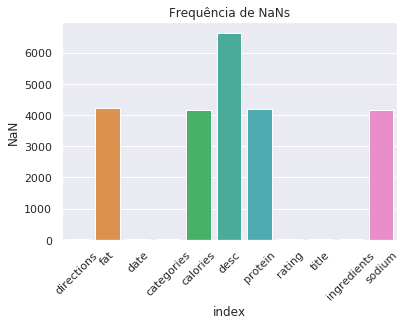

In [2]:
df_nan = pd.DataFrame(df_raw.isna().sum()).rename(columns={0: 'NaN'})
sns.set(style='darkgrid')
nan_freq = sns.barplot(data=df_nan.reset_index(), x='index', y='NaN')
nan_freq.set_xticklabels(nan_freq.get_xticklabels(), rotation=45)
nan_freq.set_title('Frequência de NaNs')

### Existem diversas formas de lidar com esse tipo de problema. Para esse caso, estaremos eliminando as instâncias que possuam qualquer missing value, com excessão somente a coluna "desc". Iremos ignorar essa coluna porque seu impacto aparente na geração de inferências e modelos não é grande. Futuramente, vamos simplesmente tratar os missing values ou a falta de uma descrição nessa coluna como 0 e a existência de uma descrição como 1.

In [3]:
remove_if_nan = ['directions', 'fat', 'date', 'categories', 'calories', 'protein', 'rating', 'title', 'ingredients', 'sodium']
df = df_raw.dropna(subset=remove_if_nan)
df

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0
5,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,This recipe can be prepared in 45 minutes or l...,19.0,4.375,The Best Blts,[2 1/2 cups (lightly packed) fresh basil leave...,1042.0
...,...,...,...,...,...,...,...,...,...,...,...
20125,[Beat whites in a bowl with an electric mixer ...,2.0,2004-08-20 04:00:00+00:00,"[Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...",28.0,None,2.0,3.125,Parmesan Puffs,"[2 large egg whites, 3 oz Parmigiano-Reggiano,...",64.0
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54+00:00,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",583.0
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20+00:00,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",652.0
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00+00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",517.0


### Vamos considerar também que qualquer prato deve conter valor calórico maior que zero e algum outro nutriente. Instâncias que não satisfaçam alguma das condições anteriores, serão desconsideradas.

In [4]:
df = df[df.calories > 0]
df = df[df.protein + df.fat + df.sodium > 0]
df

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0
5,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,This recipe can be prepared in 45 minutes or l...,19.0,4.375,The Best Blts,[2 1/2 cups (lightly packed) fresh basil leave...,1042.0
...,...,...,...,...,...,...,...,...,...,...,...
20125,[Beat whites in a bowl with an electric mixer ...,2.0,2004-08-20 04:00:00+00:00,"[Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...",28.0,None,2.0,3.125,Parmesan Puffs,"[2 large egg whites, 3 oz Parmigiano-Reggiano,...",64.0
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54+00:00,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",583.0
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20+00:00,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",652.0
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00+00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",517.0


### Por último, vamos eliminar as instâncias duplicadas (caso hajam). Será considerada uma instância duplicada aquela que contiver um título repetido. Vamos verificar se existem duplicadas comparando os tamanhos de DataFrames.

In [5]:
df = df.drop_duplicates('title')
df

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0
5,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,This recipe can be prepared in 45 minutes or l...,19.0,4.375,The Best Blts,[2 1/2 cups (lightly packed) fresh basil leave...,1042.0
...,...,...,...,...,...,...,...,...,...,...,...
20124,[Wash spareribs. Remove excess fat and gristle...,80.0,2004-08-20 04:00:00+00:00,"[Pork, Appetizer, Bake, Marinate, Sherry, Fall...",998.0,None,55.0,3.750,Chinese Barbecued Spareribs,"[1 side pork spareribs, about 3 pounds, 1/2 cu...",2027.0
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54+00:00,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",583.0
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20+00:00,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",652.0
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00+00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",517.0


### Havia quase 2000 instâncias duplicadas e todas foram eliminadas. Por último, vamos verficiar a existência de outliers nos dados.

Text(0, 0.5, 'Value')

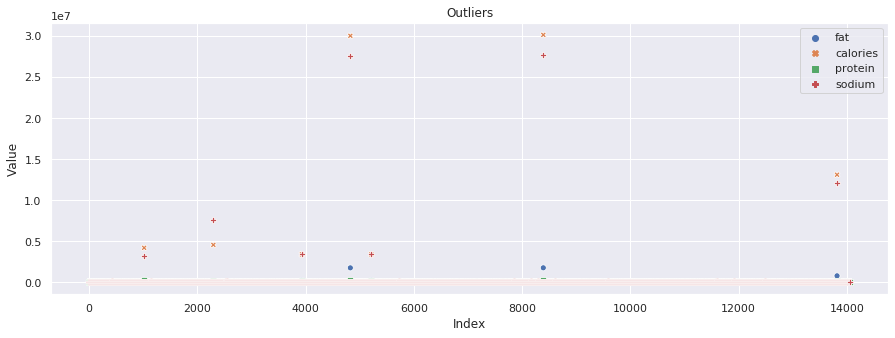

In [6]:
df = df.reset_index(drop=True)
cols_to_drop = ['directions', 'date', 'categories', 'desc', 'title', 'ingredients', 'rating']
df_nutrients = df.drop(cols_to_drop, axis=1).astype(float)

plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients)
outliers.set_title('Outliers')
outliers.set_xlabel('Index')
outliers.set_ylabel('Value')

### É perceptível a existência de outliers em todos os nutrientes, exceto na proteína. Vamos começar tratando as calorias e o sódio. Tomando como base a dieta de um adulto comum, cuja ingestão calórica diária é de aproximadamente 2200 calorias, vou remover instâncias que contarem com mais de 2500 calorias, para dar uma margem de erro e aceitar a existência de alguns pratos com valor calórico acima do normal. Já para o sódio, o valor médio diário ingerido por um americano, que já ingere acima do recomendado, é de 3500 mg. Apesar do recomendado diariamente ser 2200 mg, vamos aceitar a existência de alguns pratos contendo essa quantidade bem acima do comum.

Text(0, 0.5, 'Value')

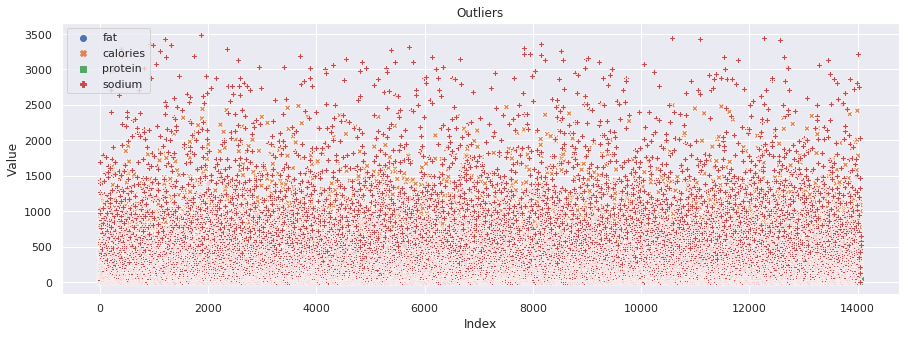

In [7]:
df = df[df.calories < 2500]
df = df[df.sodium < 3500]
df_nutrients = df.drop(cols_to_drop, axis=1).astype(float)

plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients)
outliers.set_title('Outliers')
outliers.set_xlabel('Index')
outliers.set_ylabel('Value')

### O gráfico acima parece bem mais aceitável, mas ele falha em mostrar a distribuição de gordura e proteínas. Precisamos verificar cada ingrediente individualmente para ter certeza de que a avaliação está correta.

Text(0, 0.5, 'mg')

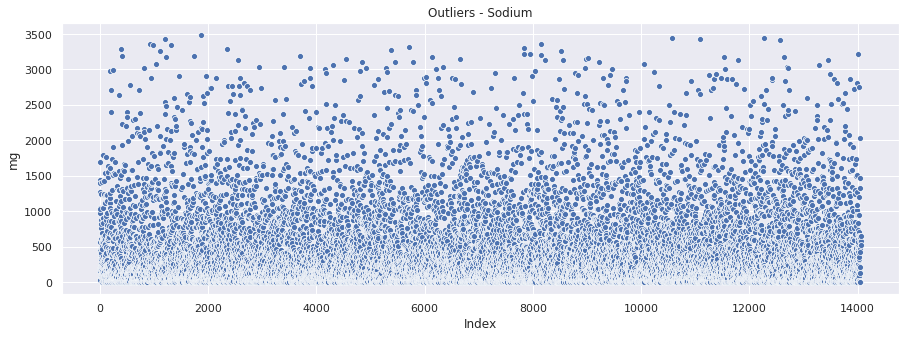

In [8]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.sodium)
outliers.set_title('Outliers - Sodium')
outliers.set_xlabel('Index')
outliers.set_ylabel('mg')

Text(0, 0.5, 'cal')

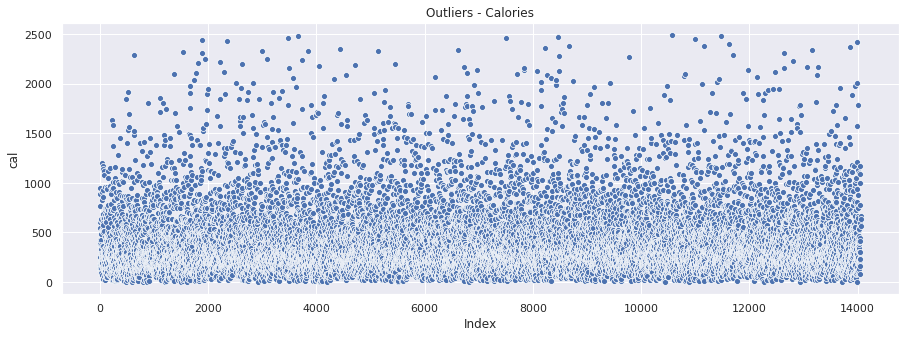

In [9]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.calories)
outliers.set_title('Outliers - Calories')
outliers.set_xlabel('Index')
outliers.set_ylabel('cal')

Text(0, 0.5, 'g')

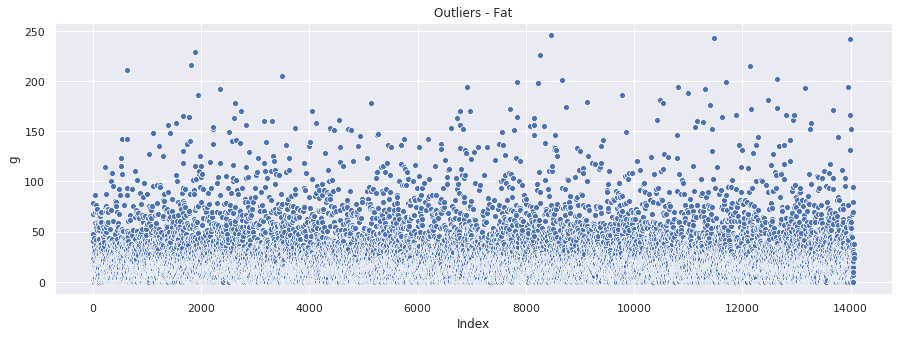

In [10]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.fat)
outliers.set_title('Outliers - Fat')
outliers.set_xlabel('Index')
outliers.set_ylabel('g')

Text(0, 0.5, 'g')

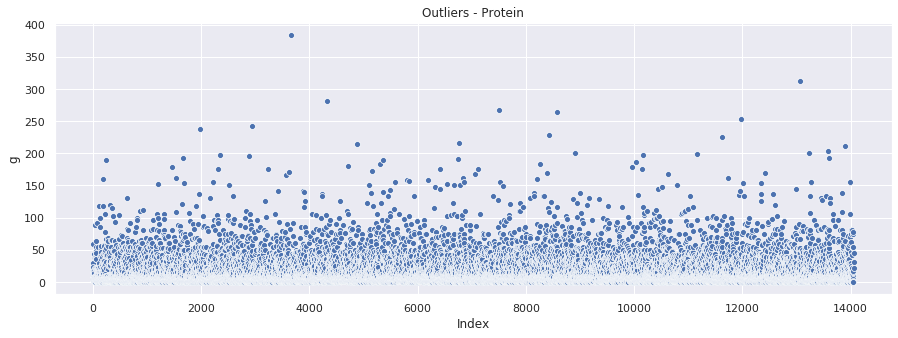

In [11]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.protein)
outliers.set_title('Outliers - Protein')
outliers.set_xlabel('Index')
outliers.set_ylabel('g')

### Observando individualmente, parece que alguns valores de todos os nutrientes estão muito diferentes da média. Portanto, vamos considerar somente os valores até o percentil 97.5%.

In [12]:
df = df[df.protein < df.protein.quantile(0.975)]
df = df[df.fat < df.fat.quantile(0.975)]
df = df[df.calories < df.calories.quantile(0.975)]
df = df[df.sodium < df.sodium.quantile(0.975)]
df = df.reset_index(drop=True)
df_nutrients = df.drop(cols_to_drop, axis=1).astype(float)

### Vamos agora verificar cada nutriente individualmente mais uma vez.

Text(0, 0.5, 'mg')

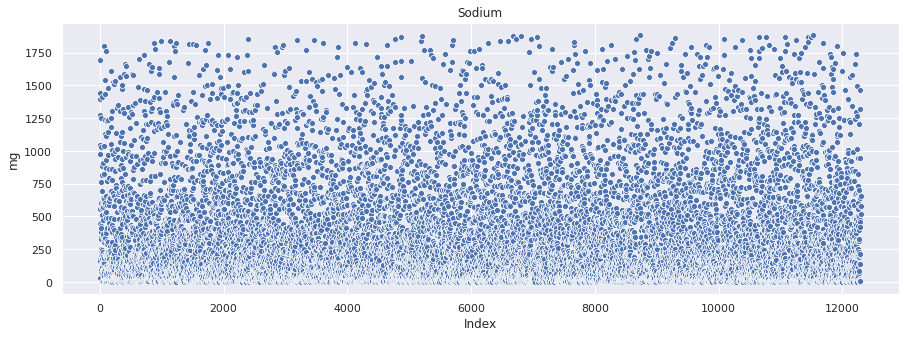

In [13]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.sodium)
outliers.set_title('Sodium')
outliers.set_xlabel('Index')
outliers.set_ylabel('mg')

Text(0, 0.5, 'cal')

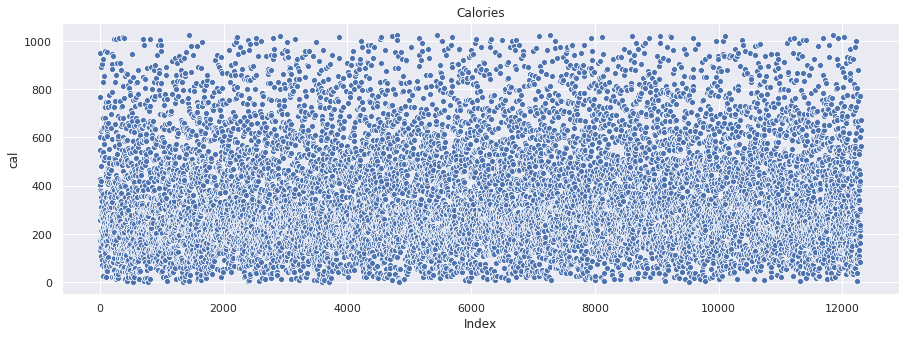

In [14]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.calories)
outliers.set_title('Calories')
outliers.set_xlabel('Index')
outliers.set_ylabel('cal')

Text(0, 0.5, 'g')

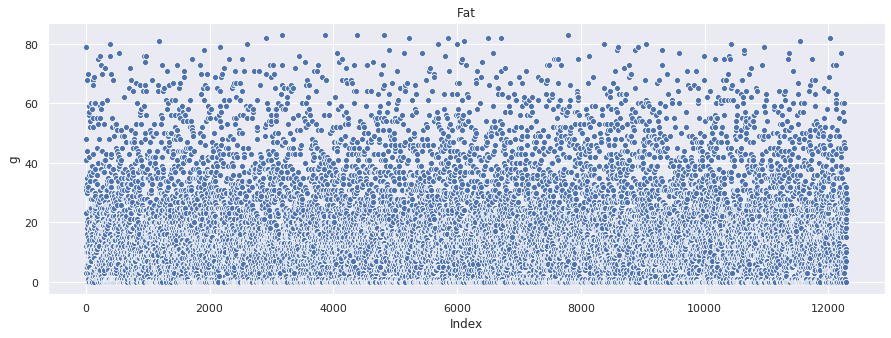

In [15]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.fat)
outliers.set_title('Fat')
outliers.set_xlabel('Index')
outliers.set_ylabel('g')

Text(0, 0.5, 'g')

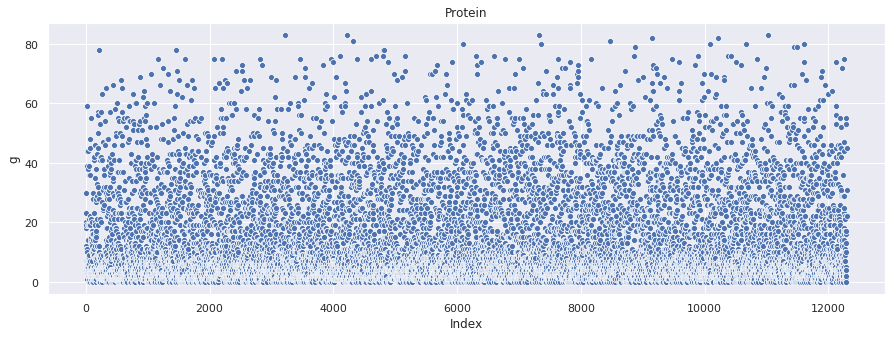

In [16]:
plt.figure(figsize=(15, 5))
outliers = sns.scatterplot(data=df_nutrients.protein)
outliers.set_title('Protein')
outliers.set_xlabel('Index')
outliers.set_ylabel('g')

### Agora os valores parecem estar mais normalizados. Vamos agora fazer uma análise das "ratings". É preciso averiguar se existem avaliações fora de escopo. As avaliações são uma nota dada aos pratos que vão de 0 a 5.

Text(0, 0.5, 'Count')

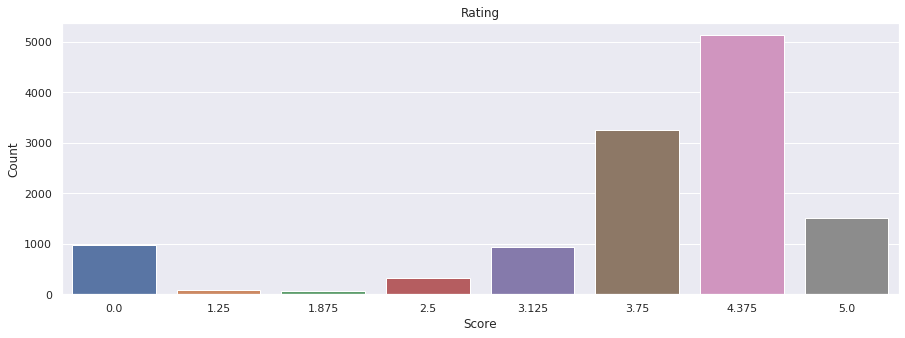

In [17]:
plt.figure(figsize=(15, 5))
outliers_df = pd.DataFrame(df.groupby(by=['rating'])['directions'].count())
outliers_df = outliers_df.reset_index().rename(columns={'directions': 'count', 'index': 'rating'})
outliers = sns.barplot(data=outliers_df, x='rating', y='count')
outliers.set_title('Rating')
outliers.set_xlabel('Score')
outliers.set_ylabel('Count')

### A princípio, não é necessário fazer uma limpeza relacionada à avaliação. Todos os valores encontram-se entre 0 e 5. A maior concentração de avaliações acontece nas maiores notas. É possível inferir que, dentre os votantes, a grande maioria tende a dar boas avaliações. Poucos são os que dão avaliações negativas. Entre as avaliações mais baixas, a que mais se destaca é a nota 0. Essa diferença grande gera uma suspeita de que a abstenção de votos conta como 0 no dataset.

### Estatisticamente faz mais sentido remover as instâncias com avaliação 0 do dataset. Assim estaremos fazendo a avaliação somente dos votantes. Os não votantes são uma população distinta e podem apresentar comportamento diferente, diminuindo a acurácia das inferências realizadas aqui. Por essa razão, vamos remover estas instâncias.

In [18]:
df = df[df.rating > 0]
df

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0
4,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,This recipe can be prepared in 45 minutes or l...,19.0,4.375,The Best Blts,[2 1/2 cups (lightly packed) fresh basil leave...,1042.0
...,...,...,...,...,...,...,...,...,...,...,...
12290,"[Drain clams, reserving juices. Sauté salt por...",10.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Milk/Cream, Pork, Potato, Sauté, T...",235.0,The early Yankees often cooked local shellfish...,17.0,3.125,Shellfish Chowder with Fresh Thyme,"[2 6 1/2-ounce cans chopped clams with juices,...",422.0
12291,[Mix first 4 ingredients in large pitcher. Cov...,0.0,2004-08-20 20:58:12+00:00,"[Fruit Juice, Liqueur, Vodka, Alcoholic, Cockt...",84.0,None,0.0,3.750,Orange-Tini,"[4 cups water, 1 750-ml bottle vodka (about 3 ...",5.0
12292,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54+00:00,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",583.0
12293,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20+00:00,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",652.0


### Agora o dataset parece bem processado. Na próxima seção, vamos visualizar dados de forma semelhante à feita até o momento. Além disso, vamos tentar inferir algumas informações desses dados, gerando respostas para o exercício 4, que busca correlações entre as informações do dataset e as avaliações dos usuários.

## 1.3. Visualização dos dados

### Agora vamos trabalhar a correlação e informações diversas que os dados tratados nos dão.

### Vamos primeiro verificar a frequência das notas dos usuários:

Text(0, 0.5, 'Count')

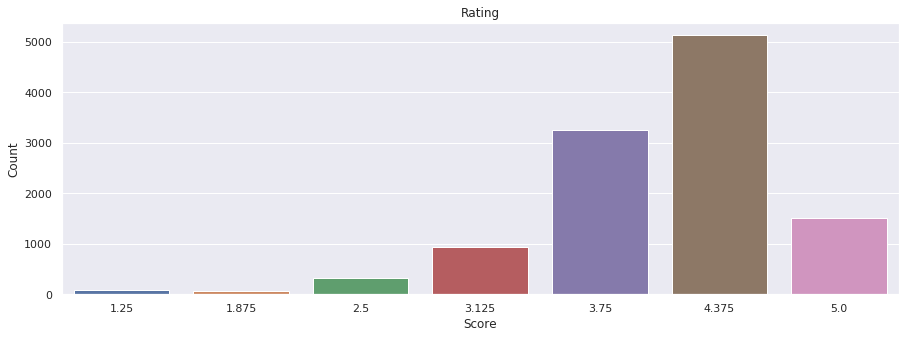

In [19]:
plt.figure(figsize=(15, 5))
rating_df = pd.DataFrame(df.groupby(by=['rating'])['directions'].count())
rating_df = rating_df.reset_index().rename(columns={'directions': 'count', 'index': 'rating'})
rating = sns.barplot(data=rating_df, x='rating', y='count')
rating.set_title('Rating')
rating.set_xlabel('Score')
rating.set_ylabel('Count')

### As avaliações feitas anteriormente para as avaliações se mantém, já que a única diferença foi a remoção das avaliações nulas.

### Agora vamos verificar como cada nutriente se comporta de acordo com a avaliação da receita.

Text(0, 0.5, 'cal')

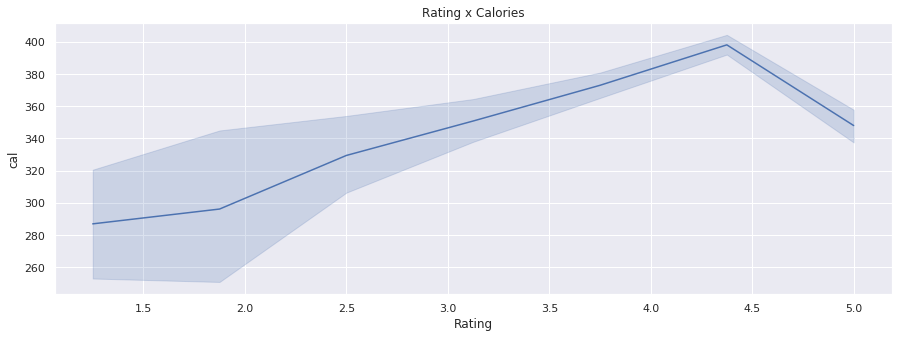

In [20]:
plt.figure(figsize=(15, 5))
rating_cal = sns.lineplot(x='rating', y='calories', markers=True, data=df)
rating_cal.set_title('Rating x Calories')
rating_cal.set_xlabel('Rating')
rating_cal.set_ylabel('cal')

Text(0, 0.5, 'mg')

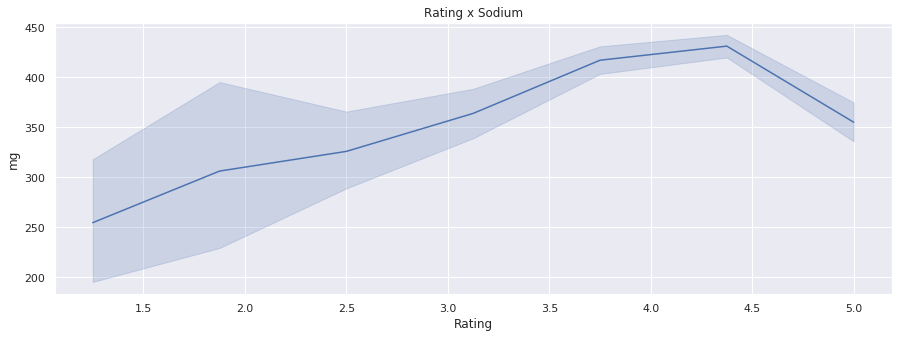

In [21]:
plt.figure(figsize=(15, 5))
rating_sodium = sns.lineplot(x='rating', y='sodium', markers=True, data=df)
rating_sodium.set_title('Rating x Sodium')
rating_sodium.set_xlabel('Rating')
rating_sodium.set_ylabel('mg')

Text(0, 0.5, 'g')

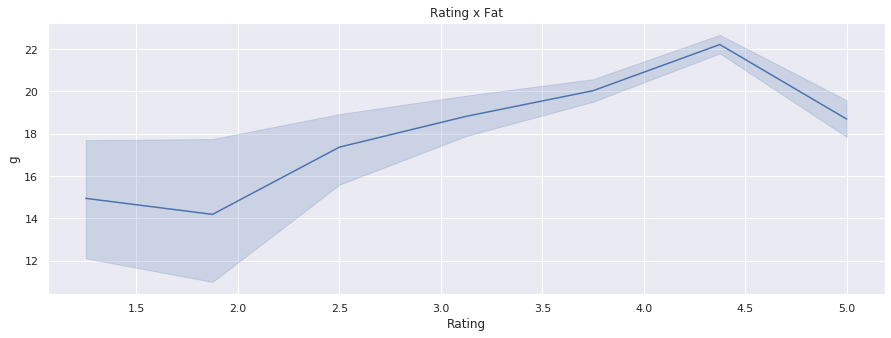

In [22]:
plt.figure(figsize=(15, 5))
rating_fat = sns.lineplot(x='rating', y='fat', markers=True, data=df)
rating_fat.set_title('Rating x Fat')
rating_fat.set_xlabel('Rating')
rating_fat.set_ylabel('g')

Text(0, 0.5, 'g')

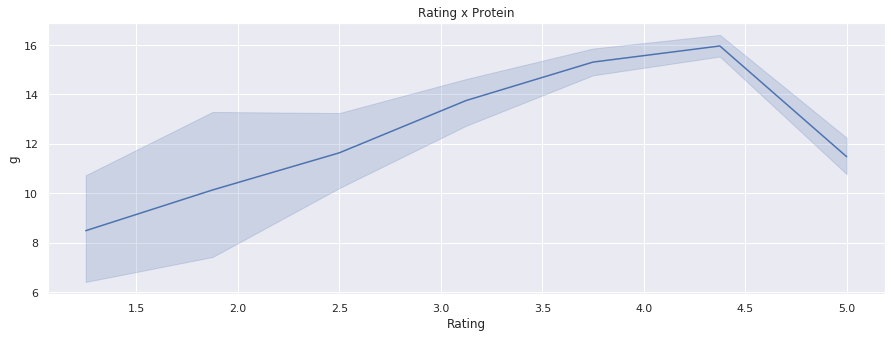

In [23]:
plt.figure(figsize=(15, 5))
rating_protein = sns.lineplot(x='rating', y='protein', markers=True, data=df)
rating_protein.set_title('Rating x Protein')
rating_protein.set_xlabel('Rating')
rating_protein.set_ylabel('g')

### No exercício 4 se pergunta se há alguma característica presente nos dados que seja determinante na nota alta de uma receita. A partir dos gráficos de nutrientes, é visível que o valor das notas cresce com cada nutriente. A interpretação aparente dessa informação é que, geralmente as refeições mais bem avaliadas popularmente, são aquelas que não são consideradas saudáveis (altos valores de gordura, calorias e sódio) e possuem bastante carne (associada à proteína). Apesar disso, há uma diferenciação entre a nota 4.375 e a nota 5. É um intervalo em que a quantidade de nutrientes decresce em todos os gráficos. É plausível atribuir isto à questão de saúde de receitas com este excesso de nutrientes. Estas receitas tem um impacto negativo no longo prazo à saude dos indivíduos, então as pessoas tendem a avaliar este tipo de prato com nota alta, mas não máxima.

### Para o exercício 6, será necessário construir um classificador. Pensando no futuro, vamos fazer algumas mudanças no dataset a partir de agora, o que também tornará possível fazer algumas outras inferências.

### A primeira mudança será a transformação da coluna de ingredientes em n + 1 colunas, onde n corresponde ao número total de ingredientes e o 1 corresponde em uma coluna que expõe o número de ingredientes utilizados em cada receita. O primeiro passo é mais complexo. Para torná-lo possível, serão utilizadas técnicas de processamento de texto. As frases contidas em cada sublista da coluna de ingredientes será avaliada semanticamente, em busca de substantivos. Os substantivos presentes em cada sublista serão cruzados com o título da receita, instruções e descrição. Substantivos que se repetirem ao menos uma vez, serão considerados potenciais ingredientes e serão transformados em colunas. Essas colunas conterão valores binários, indicando a presença ou não do ingrediente em questão na receita. O segundo passo é simples e só vai transformar a coluna de ingredientes em n_ingredientes, que conterá a informação do número de ingredientes utilizados na receita, além de outras modificações explicadas adiante.

In [24]:
if os.path.isfile('data.pkl') and os.path.isfile('ingredient_cols_names.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    with open('ingredient_cols_names.pkl', 'rb') as f:
        ingredient_cols_names = pickle.load(f)
        
else:
    stemmer = SnowballStemmer('english')
    data = df.to_numpy()
    ingredient_cols_names = []
    for i in range(len(data)):
        for ing in data[i, 9]:
            tokens = nltk.word_tokenize(ing.lower()) # separa a frase em tokens
            tags = nltk.pos_tag(tokens) # atribui valor semântico à palavra
            nouns = []
            for word_eval in tags:
                if 'NN' in word_eval[1]: # 'NN' é a string que representa substantivos
                    nouns.append(word_eval[0])
            for word in nouns:
                if word.isalpha():
                    word = stemmer.stem(word)
                    for k in [8, 0, 3, 5]: # são as colunas de title, directions, categories e desc respectivamente
                        if data[i, k] is not None:
                            if not isinstance(data[i, k], list):
                                if word in data[i, k].lower():
                                    if word not in ingredient_cols_names: # verifica se a coluna da feature não existe
                                        ingredient_cols_names.append(word)
                                        new_col = np.zeros((data.shape[0], 1))
                                        data = np.concatenate((data, new_col), axis=1)
                                        data[i, -1] = 1
                                    else: # caso já exista
                                        idx = ingredient_cols_names.index(word)
                                        data[i, idx + 10] = 1
                            else:
                                for l in range(len(data[i, k])):
                                    if word in data[i, k][l].lower():
                                        if word not in ingredient_cols_names:
                                            ingredient_cols_names.append(word)
                                            new_col = np.zeros((data.shape[0], 1))
                                            data = np.concatenate((data, new_col), axis=1)
                                            data[i, -1] = 1
                                        else:
                                            idx = ingredient_cols_names.index(word)
                                            data[i, idx + 10] = 1
    
    if not os.path.isfile('data.pkl') or not os.path.isfile('ingredient_cols_names.pkl'):
        with open('data.pkl', 'wb') as f:
            pickle.dump(data, f)
        with open('ingredient_cols_names.pkl', 'wb') as f:
            pickle.dump(ingredient_cols_names, f)

### Agora vamos fazer o segundo passo. Na realização desse passo, outras informações serão modificadas e inseridas como features também. A coluna de "directions" terá os valores substituídos simplesmente pelo número de instruções para elaborar a receita. A coluna de data terá seu valor substituído pelo valor ordinal da data, possibilitando visualizá-la em gráficos. A coluna de descrição será substituída por 0, caso não haja descrição, ou 1, caso haja. Por último, a coluna de ingredientes terá os valores substituídos pelo número de ingredientes utilizados em cada receita.

In [25]:
if os.path.isfile('data2.pkl') and os.path.isfile('label_list.pkl'):
    with open('data2.pkl', 'rb') as f:
        data2 = pickle.load(f)
    with open('label_list.pkl', 'rb') as f:
        label_list = pickle.load(f)
    
else:
    data2 = data
    label_list = []
    last_col = data2.shape[1]
    for i in range(len(data2)):
        for categ in data2[i, 3]: # extração de cada categoria
            if categ in label_list: # verificação de se já existe uma coluna para a categoria
                idx = label_list.index(categ)
                data2[i, last_col + idx] = 1 # como já existe, se atribui o valor 1 no elemento apropriado
            else:
                label_list.append(categ)
                new_col = np.zeros((len(data2), 1))
                data2 = np.concatenate((data2, new_col), axis=1) # criação da coluna para representar uma nova feature
                data2[i, -1] = 1

    for i in range(len(data2)):
        for j in [0, 2, 5, 9]:
            if j == 0: # valor de directions substituído pela quantidade de instruções
                data2[i, j] = len(data2[i, j]) 
            elif j == 2: # substituição da data pelo valor ordinal da data
                data2[i, j] = datetime.strptime(str(data2[i, j])[:10], '%Y-%m-%d').date().toordinal()
            elif j == 5: # binarização do desc
                if data2[i, j] is None or isinstance(data2[i, j], str) or np.isnan(data2[i, j]):
                    data2[i, j] = 0
                else:
                    data2[i, j] = 1
            elif j == 9: # os ingredientes já viraram features, agora a coluna diz quantos ingredientes se usam
                data2[i, j] = len(data2[i, j])
                
    if not os.path.isfile('data2.pkl') or not os.path.isfile('label_list.pkl'):
        with open('data2.pkl', 'wb') as f:
            pickle.dump(data2, f)
        with open('label_list.pkl', 'wb') as f:
            pickle.dump(label_list, f)

### Agora o array numpy será convertido para um DataFrame novamente, possibilitando que nós visualizemos os resultados das modificações realizadas.

In [26]:
original_cols_names = ['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium']
cols_names = original_cols_names + ingredient_cols_names + label_list
dict_cols_names = {}
for i in range(len(cols_names)):
    dict_cols_names.update({i: cols_names[i]})

for i in range(len(data2)):
    data2[i, 3] = len(data2[i, 3])
    
df_features = pd.DataFrame(data2)
df_features = df_features.rename(columns=dict_cols_names)
df_features = df_features.drop(columns=['title'])
df_features

,directions,fat,date,categories,calories,desc,protein,rating,ingredients,sodium,...,Lasagna,Houston,Brownie,Martini,Pacific Palisades,Alaska,Sardine,Anthony Bourdain,Meatloaf,Sourdough
0,3,7,732555,11,426,0,30,2.5,15,559,...,0,0,0,0,0,0,0,0,0,0
1,5,23,731813,11,403,0,18,4.375,28,1439,...,0,0,0,0,0,0,0,0,0,0
2,2,7,731813,7,165,0,6,3.75,6,165,...,0,0,0,0,0,0,0,0,0,0
3,1,32,731813,11,547,0,20,3.125,6,452,...,0,0,0,0,0,0,0,0,0,0
4,3,79,731813,10,948,0,19,4.375,9,1042,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,2,10,731813,11,235,0,17,3.125,11,422,...,0,0,0,0,0,0,0,0,0,0
11310,1,0,731813,9,84,0,0,3.75,7,5,...,0,0,0,1,0,0,0,0,0,0
11311,2,28,733100,16,671,0,22,4.375,8,583,...,0,0,0,0,0,0,0,0,0,0
11312,6,38,732240,15,563,0,31,4.375,17,652,...,0,0,0,0,0,0,0,0,0,0


### Apesar de ser um bom método para gerar a lista de ingredientes utilizados nas receitas, ele não é perfeito. Algumas palavras que foram consideradas como ingredientes, simplesmente não são. Foi gerada a seguinte lista contendo um grande número de falsos-positivos. Esta lista foi feita manualmente e tomou entre 1h e 2h.

In [27]:
bad_substrings = ['or','and','medium','to','in','crosswis','larg','of','dri','center','remov','into','chill','all','cup','port','french','red','can','reserv','dice','strip','about','slice','cut','tablespoon','asian','white','pale','green','tablespoons','the','inch','accompani','divid','fine','teaspoon','chop','jar','with','minc','spray','bake','cups','stick','room','temperatur','light','brown','mini','kiss','whole','fresh','from','solid','piec','not','side','a','heavy','pot','lid','small','dry','drain','pat','spring','blossom','smooth','season','at','some','melt','sea','peel','part','boil','for','halv','powder','shorten','skin','spoon','as','warm','grill','key','soak','enough','cold','cover','them','by','tast','an','crush','mexican','each','extract','food','ground','golden','raisin','cool','half','pit','blue','romain','then','packag','day','old','if','stand','electr','mixer','g','mix','more','s','roast','pinch','mash','one','ingredi','are','top','core','be','star','rough','serv','long','leg','gold','cube','on','processor','other','well','stem','ounc','use','thin','winter','option','recip','hot','includ','slight','liquid','segment','ring','bowl','cutlet','over','coat','spread','skirt','con','crumbl','pound','shave','peeler','trim','head','steam','prune','heat','almost','total','smoke','thick','heirloom','color','diagon','fri','x','sparkl','tabl','yellow','end','prepar','skewer','minut','squar','confection','mill','mortar','age','sharp','parchment','paper','need','wild','dress','is','contain','rack','kitchen','twine','see','bonito','meal','tail','altern','king','plus','lengthwis','butterfli','your','butcher','frozen','pure','button','maker','rub','chunck','round','cutter','do','bottom','weight','tripl','sec','pint','soften','fit','flute','blade','dust','ramp','bouquet','slicer','few','drop','bone','grinder','flank','lb','dish','picant','new','h','twist','foil','lean','quarter','clean','befor','it','so','nonfat','per','hour','up','angel','hair','oz','soft','panela','line','press','shred','mixtur','temper','ten','ink','mild','hatch','short','b','six','lake','such','tight','n','d','discard','point','section','burner','that','hook','lower','clip','fill','waterproof','marker','oven','fire','until','scraper','offset','than','spatula','sand','au','m','roug','m','twig','stuf','husk','but','wash','cure','no','plastic','storag','tub','dispos','sawdust','charcoal','starter','approx','left','fill','thanksgiv','leftov','ear','la','raw','store','tube','cep','metal','popper','wood','gas','cap','split','reduc','litr','fig','boneless','prefer','slow','cooker','canadian','plain','italian','passion','made','perfect','glass','club','liner','american','zealand','bag','grand','box','excess','simpl','wheel','snow','out','own','process','o','note','dark','carcass','domest','possibl','foot','feet','silken','anaheim','mexico','tostada','casera','scrape','log','ca','regular','special','jerusalem','tropic','crystal','outer','orient','good','madeira','you','i','love','scissor','ad','rins','stack','chines','delici','basic','gram','kilogram','activ','extra','coin','just','desire','pin','help','holiday','rock','intact','two','tip','tear','game','disk','like','unsalt','artisan','local','blood','off','doubl','english','persian','make','bass','shoot','also','most','back','spanish','santa','stripe','their','wide','allow','indian','unsulfur','boston','torch','shallow','often','unseason']

### Depois disso apagamos colunas que não deveriam ter sido criadas, por não se tratar de ingredientes.

In [28]:
cols_names_feat = list(df_features)
cols_to_remove = []
for i in bad_substrings:
    if i in cols_names_feat:
        cols_to_remove.append(i)
df_features = df_features.drop(cols_to_remove, axis=1)
df_features = df_features.loc[:,~df_features.columns.duplicated()]
df_features

,directions,fat,date,categories,calories,desc,protein,rating,ingredients,sodium,...,Lasagna,Houston,Brownie,Martini,Pacific Palisades,Alaska,Sardine,Anthony Bourdain,Meatloaf,Sourdough
0,3,7,732555,11,426,0,30,2.5,15,559,...,0,0,0,0,0,0,0,0,0,0
1,5,23,731813,11,403,0,18,4.375,28,1439,...,0,0,0,0,0,0,0,0,0,0
2,2,7,731813,7,165,0,6,3.75,6,165,...,0,0,0,0,0,0,0,0,0,0
3,1,32,731813,11,547,0,20,3.125,6,452,...,0,0,0,0,0,0,0,0,0,0
4,3,79,731813,10,948,0,19,4.375,9,1042,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,2,10,731813,11,235,0,17,3.125,11,422,...,0,0,0,0,0,0,0,0,0,0
11310,1,0,731813,9,84,0,0,3.75,7,5,...,0,0,0,1,0,0,0,0,0,0
11311,2,28,733100,16,671,0,22,4.375,8,583,...,0,0,0,0,0,0,0,0,0,0
11312,6,38,732240,15,563,0,31,4.375,17,652,...,0,0,0,0,0,0,0,0,0,0


### Vamos agora gerar as últimas visualizações de dados relativos às avaliações, o que nos aprofunda um pouco mais no exercício 4, antes de responder os próximos exercícios. Primeiramente vamos avaliar às avaliações cruzadas com o tempo.

Text(0, 0.5, 'Rating')

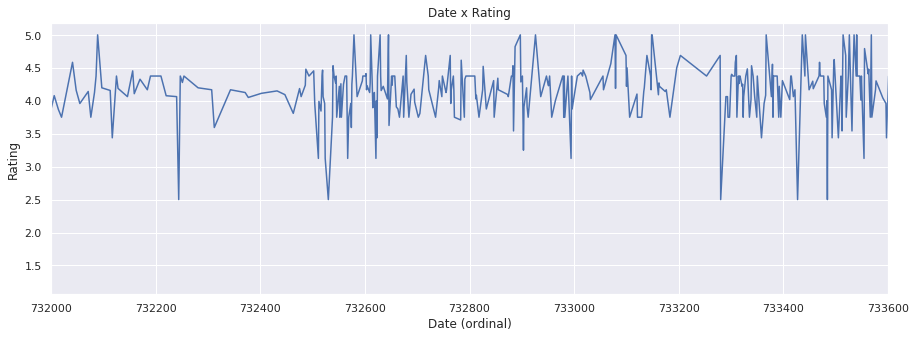

In [29]:
df_features = df_features.astype(float)
df_features_date = df_features[['date', 'rating']].groupby('date').mean().reset_index()
plt.figure(figsize=(15, 5))
rating_date = sns.lineplot(x='date', y='rating', data=df_features_date)
rating_date_axes = rating_date.axes
rating_date_axes.set_xlim(732000, 733600)
rating_date.set_title('Date x Rating')
rating_date.set_xlabel('Date (ordinal)')
rating_date.set_ylabel('Rating')

### Pelo gráfico, não há motivos para suspeitar que o passar do tempo tenha uma influência em como as pessoas votam.

### Vamos também avaliar a quantidade de instruções com a avaliação dada aos pratos.

Text(0, 0.5, 'Rating')

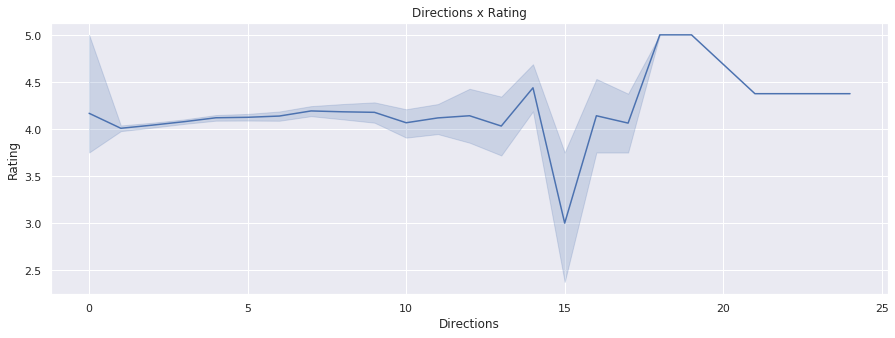

In [30]:
plt.figure(figsize=(15, 5))
rating_directions = sns.lineplot(x='directions', y='rating', markers=True, data=df_features)
rating_directions.set_title('Directions x Rating')
rating_directions.set_xlabel('Directions')
rating_directions.set_ylabel('Rating')

### O número de passos está diretamente ligado à complexidade de se preparar uma receita. A princípio, não parece haver uma correlação clara, dada a margem de erro.
### Vamos também avaliar o número de ingredientes com a avaliação dada aos pratos.

Text(0, 0.5, 'Rating')

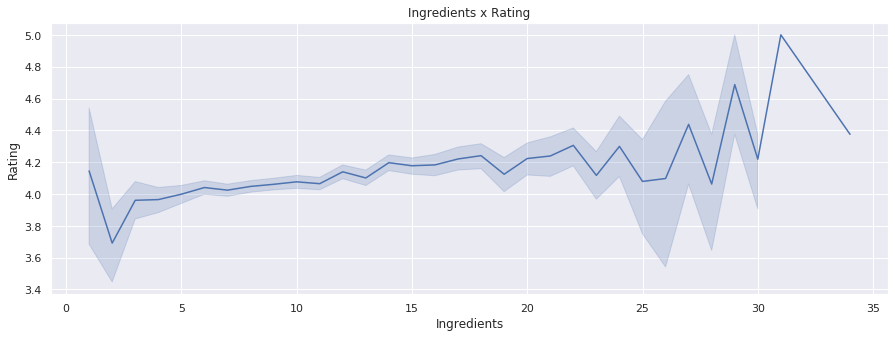

In [31]:
plt.figure(figsize=(15, 5))
rating_ingredients = sns.lineplot(x='ingredients', y='rating', markers=True, data=df_features)
rating_ingredients.set_title('Ingredients x Rating')
rating_ingredients.set_xlabel('Ingredients')
rating_ingredients.set_ylabel('Rating')

### A avaliação parece crescer de forma discreta com o aumento do número de ingredientes. Quando o número de ingredientes se torna muito alto, a margem de erro também é, impossibilitanto afirmar com certeza se esse é o caso, mas a linha de tendência mostra essa possibilidade.

### Por último, vamos avaliar se há uma relação entre a existência de uma descrição e uma boa avaliação.

In [32]:
df_features[['desc', 'rating']].groupby('desc').mean().reset_index()

,desc,rating
0,0.0,4.080453


### Nesta etapa, percebi que nenhuma das instâncias atuais contém uma descrição. Então, não há uma análise para ser feita relicionada a esta variável e ela pode ser removida do DataFrame, já que não influencia em nada.

In [33]:
df_features = df_features.drop(['desc'], axis=1)
df_features

,directions,fat,date,categories,calories,protein,rating,ingredients,sodium,stock,...,Lasagna,Houston,Brownie,Martini,Pacific Palisades,Alaska,Sardine,Anthony Bourdain,Meatloaf,Sourdough
0,3.0,7.0,732555.0,11.0,426.0,30.0,2.500,15.0,559.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,23.0,731813.0,11.0,403.0,18.0,4.375,28.0,1439.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,7.0,731813.0,7.0,165.0,6.0,3.750,6.0,165.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,32.0,731813.0,11.0,547.0,20.0,3.125,6.0,452.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,79.0,731813.0,10.0,948.0,19.0,4.375,9.0,1042.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,2.0,10.0,731813.0,11.0,235.0,17.0,3.125,11.0,422.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,1.0,0.0,731813.0,9.0,84.0,0.0,3.750,7.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11311,2.0,28.0,733100.0,16.0,671.0,22.0,4.375,8.0,583.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11312,6.0,38.0,732240.0,15.0,563.0,31.0,4.375,17.0,652.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Exercícios

## 2.1. A que categorias pertencem as comidas mais calóricas?

### Primeiramente, vamos pensar a respeito da pergunta.

In [34]:
df_features.sort_values(by=['calories'], ascending=False)

,directions,fat,date,categories,calories,protein,rating,ingredients,sodium,stock,...,Lasagna,Houston,Brownie,Martini,Pacific Palisades,Alaska,Sardine,Anthony Bourdain,Meatloaf,Sourdough
5024,1.0,51.0,731813.0,7.0,1025.0,35.0,4.375,12.0,981.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1340,5.0,61.0,731813.0,8.0,1024.0,59.0,4.375,23.0,1160.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6703,4.0,54.0,731813.0,14.0,1023.0,11.0,3.750,12.0,528.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4421,6.0,65.0,732747.0,9.0,1023.0,78.0,4.375,12.0,845.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10891,3.0,50.0,731813.0,10.0,1023.0,44.0,4.375,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,1.0,0.0,731813.0,2.0,2.0,0.0,3.125,2.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3313,1.0,0.0,734848.0,18.0,2.0,0.0,5.000,1.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,4.0,0.0,732240.0,5.0,2.0,0.0,3.750,10.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4462,3.0,0.0,731813.0,4.0,1.0,0.0,3.750,5.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Esta pergunta é um pouco aberta. Cada uma das refeições pertence a várias categorias, inclusive as mais calóricas. Só nas 5 receitas mais calóricas, já existem 48 categorias envolvidas, talvez todas elas não sejam únicas, mas o importante é que mesmo avaliando as 10 receitas mais calóricas e extraindo informações das categorias a que elas pertencem, não seria possível fazer um ranking das categorias mais calóricas, pois elas estariam no mesmo patamar.
### Agora vamos supor que simplesmente fizéssemos a avaliação contando o número de aparições das categorias em todas as receitas, e as categorias que mais aparecessem seriam consideradas as mais calóricas. Esta abordagem também poderia ser incorreta, já que existe a possibilidade de uma categoria estar presente em grande parte das receitas com poucas calorias ou um valor médio de calorias. Isto faria com que esta categoria pudesse aparecer no topo, mesmo que esteja associado somente a um grande número de receitas sem um alto valor calórico.
### Imagino que a melhor abordagem seria fazer um ranking utilizando o valor em calorias como um peso para as categorias associadas à receita em questão. Então, as categorias que definem receitas de alto teor calórico, receberiam um peso maior na avaliação e o ranking seria elaborado com um maior grau de confiança.
### Essa abordagem com a geração de um score baseado no número de calorias de cada receita será o escolhido para responder a questão, já que parece dar uma maior confiança no resultado.

Text(0, 0.5, 'Score')

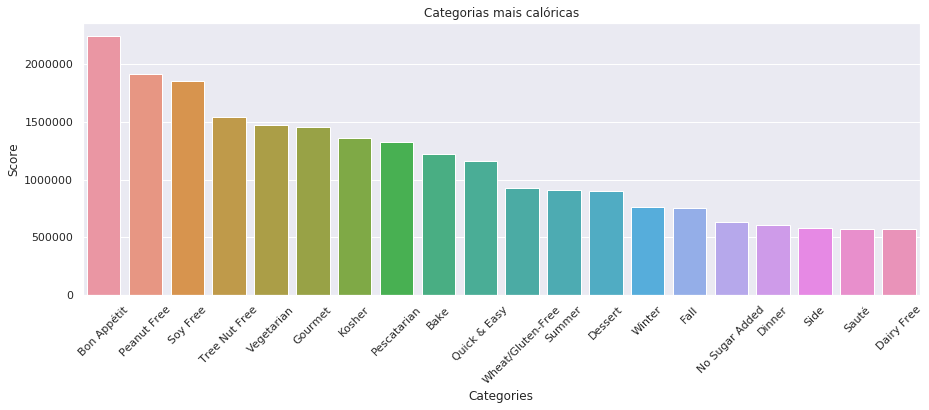

In [35]:
data_df = df.to_numpy()
categories_unique = []
for i in range(len(data_df)):
    categories_unique.append(data_df[i, 3])
categories_unique = [item for sublist in categories_unique for item in sublist]
categories_unique = set(categories_unique)

categories_weight = dict.fromkeys(categories_unique, 0)
for categ in categories_unique:
    for i in range(len(data_df)):
        if categ in data_df[i, 3]:
            weight = data_df[i, 4]
            categories_weight[categ] += weight  
score = pd.DataFrame.from_dict(dict(Counter(categories_weight)), orient='index').rename(columns={0: 'score'}).sort_values(by=['score'], ascending=False)
plt.figure(figsize=(15, 5))
score_graph = sns.barplot(data=score[:20].reset_index(), x='index', y='score')
score_graph.set_xticklabels(score_graph.get_xticklabels(), rotation=45)
score_graph.set_title('Categorias mais calóricas')
score_graph.set_xlabel('Categories')
score_graph.set_ylabel('Score')

### O gráfico acima mostra as 20 categorias mais bem avaliadas de acordo com a métrica criada.

## 2.2. Quais os top 10 ingredientes contidos nas receitas mais calóricas?

### Esta pergunta também é um pouco aberta, pelo mesmo motivo citado na questão anterior. Por esta razão, vamos usar a mesma abordagem de utilizar um sistema de score, onde os ingredientes recebem maior peso de acordo com o número de calorias do prato.
### Anteriormente, nós processamos as strings contidas na coluna original de ingredientes, para a obtenção dos substantivos, como explicado. Um dos motivos, além de gerar uma maior quantidade de features, fazendo o classificador do exercício 6 (que ainda será explicado/elaborado) ser treinado com maior número de informações, foi a resolução deste exercício. Por conta do processamento anterior, temos uma lista de ingredientes bastante limpa, o que facilita bastante a implementação do sistema de pesos.

Text(0, 0.5, 'Score')

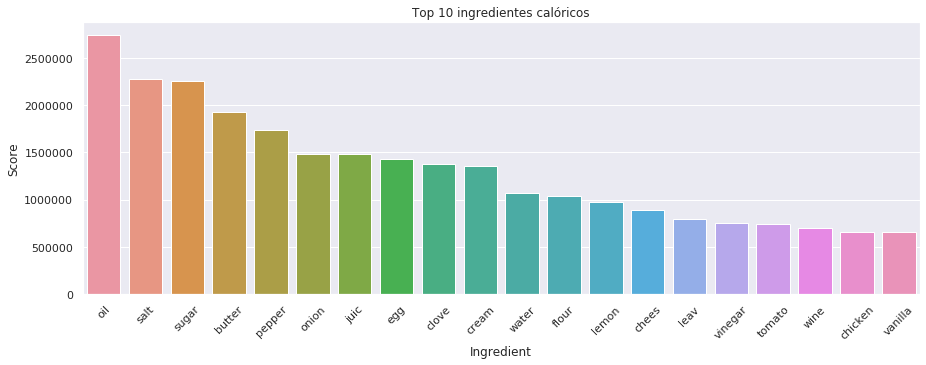

In [36]:
ingredients_unique = []
stemmer = SnowballStemmer('english')
for i in range(len(data)):
    for ing in data[i, 9]:
        tokens = nltk.word_tokenize(ing.lower())
        tags = nltk.pos_tag(tokens)
        nouns = []
        for word_eval in tags:
            if 'NN' in word_eval[1]:
                nouns.append(word_eval[0])
        for word in nouns:
            if word.isalpha():
                word = stemmer.stem(word)
                if word not in bad_substrings:
                        ingredients_unique.append([word] * int(data[i, 4]))
                    
ingredients_unique = [item for sublist in ingredients_unique for item in sublist]
ingredients_weight = dict(Counter(ingredients_unique).most_common(40))
score = pd.DataFrame.from_dict(ingredients_weight, orient='index').rename(columns={0: 'score'})

plt.figure(figsize=(15, 5))
score_graph = sns.barplot(data=score[:20].reset_index(), x='index', y='score')
score_graph.set_xticklabels(score_graph.get_xticklabels(), rotation=45)
score_graph.set_title('Top 10 ingredientes calóricos')
score_graph.set_xlabel('Ingredient')
score_graph.set_ylabel('Score')

### Pela avaliação do score, os 20 ingredientes mais comuns nas receitas mais calóricas estão listados acima, em ordem decrescente. Tomei a liberdade de apresentar 20, ao invés de 10 como pedido. É interessante mostrar dessa forma porque existem situações em que uma palavra, que na verdade não é um ingrediente, pode acabar passando, mesmo que se faça o tratamento manual das strings, como eu fiz. Neste caso, percebe-se no rank 15 a palavra "leav" (radical de leave). Provavelmente é uma palavra que aparecia com alta frequência na coluna de directions, como uma instrução, e acabou passando pelo processamento, tanto o realizado por computador, quanto realizado pelo humano (eu). 

## 2.3. Se você tivesse de recomendar três receitas baseando-se nos dados, quais seriam?

### Existem diversos tipos de recomendações baseadas nos dados. Eles possibilitam a recomendação de diversos tipos de receitas. Com bases nesses dados, estarei recomendando três receitas saudáveis. Para isto, irei calcular uma pontuação para a refeição que será dada pela seguinte expressão matemática: rating * protein / (fat + sodium). As calorias serão analisadas manualmente, por se tratar de uma informação mais subjetiva, já que uma refeição com alta dose calórica, desde que o limite diário seja respeitado, não influencia negativamente na saúde. Por fim, as melhores receitas avaliadas dessa forma, terão suas categorias analisadas para verificar se há algum ponto negativo a ser extraído com as informações categóricas.

In [37]:
df_score = df.eval('score = rating * protein / (fat + sodium)')
df_score.sort_values(by='score', ascending=False)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,score
10583,"[Cook 1 1/2 cups halved pitted cherries, 2 tab...",0.0,2013-06-28 04:00:00+00:00,"[Bourbon, Ice Cream Machine, Freeze/Chill, Qui...",132.0,None,1.0,5.000,Cherry-Bourbon Ice Cream,"[1 1/2 cups halved pitted cherries, 2 tablespo...",0.0,inf
2881,"[Cut grapefruit in half; using a small knife, ...",0.0,2013-12-03 04:00:00+00:00,"[Citrus, Breakfast, Brunch, Vegetarian, Quick ...",69.0,"My elementary school grapefruit, all grown up....",1.0,5.000,Grapefruit with Chile and Rosemary,"[1 red or pink grapefruit, 2 teaspoons raw sug...",0.0,inf
7820,"[Cut peel, including all white pith, from 2 gr...",2.0,2006-12-15 17:37:28+00:00,"[Citrus, Fruit, Dessert, Vegetarian, Quick & E...",610.0,"For something refreshing after a rich meal, lo...",10.0,3.125,Grapefruit with Campari Syrup,[3 large pink or ruby red grapefruit (4 pounds...,0.0,15.625
6544,[In a large bowl stir together semolina and fl...,1.0,2004-08-20 04:00:00+00:00,"[Pasta, Low Sodium, Gourmet]",264.0,Orecchiette (little ears) is a specialty of Ap...,9.0,4.375,Fresh Semolina Orecchiette,"[2 cups semolina, 2 cups unbleached all-purpos...",2.0,13.125
3134,[In a large bowl (large enough to hold at leas...,1.0,2004-08-20 04:00:00+00:00,"[Rice, Side, Vegetarian, Vegan, Boil, Gourmet,...",351.0,(Thai Sticky Rice),6.0,3.750,Khao Neeo,[3 cups Thai long-grain sticky (glutinous) rice],1.0,11.250
...,...,...,...,...,...,...,...,...,...,...,...,...
257,"[In a bowl whisk together vinegars, mustard, s...",20.0,2004-08-20 04:00:00+00:00,"[Mustard, Salad Dressing, Vinegar, Gourmet]",183.0,None,0.0,4.375,House Vinaigrette,"[3 tablespoons red-wine vinegar, 3 tablespoons...",147.0,0.000
2566,"[Stir together vinegar, water, garlic, bay lea...",14.0,2004-12-28 04:00:00+00:00,"[Sauce, Garlic, Herb, No-Cook, Quick & Easy, P...",129.0,The bright flavors of fresh parsley and garlic...,0.0,5.000,Chimichurri,"[3 tablespoons red-wine vinegar, 2 tablespoons...",217.0,0.000
12007,[Whisk all ingredients in medium bowl to blend...,17.0,2004-08-20 04:00:00+00:00,"[Sauce, Mustard, Onion, No-Cook, Vegetarian, M...",152.0,This recipe originally accompanied Ale-Battere...,0.0,5.000,Tartar Sauce,"[1 cup mayonnaise, 1/4 cup finely chopped dill...",182.0,0.000
1828,[In a stainless steel or enameled saucepan com...,9.0,2004-08-20 20:58:12+00:00,"[Fruit Juice, Rum, Alcoholic, Thanksgiving, Qu...",284.0,None,0.0,5.000,Hot Buttered Cranberry Cider,"[4 cups cranberry juice cocktail, 4 cups apple...",9.0,0.000


### Muitas dessas refeições bem avaliadas pela métrica utilizada, tem um valor calórico muito baixo. Possivelmente se tratam de lanches. Como a questão dá uma abertura pessoal na recomendação, eu vou adicionar considerações que me agradariam. Elas são: o prato deverá conter 600 cal ou mais e deverá conter ao menos 30 g de proteína.

In [38]:
df_score_preference = df_score[df_score.calories >= 600][df_score.protein >= 30]
df_score_preference.sort_values(by='score', ascending=False)

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,score
1607,[Heat oil in heavy large pot over high heat. S...,31.0,2004-08-20 04:00:00+00:00,"[Garlic, Tomato, Sauté, Stew, Rabbit, White Wi...",664.0,"To most Americans, Ischia, off the coast of Na...",75.0,4.375,Rabbit Cacciatore,"[3 tablespoons olive oil, 1 3 1/4-pound frozen...",161.0,1.708984
2843,[Sprinkle chicken breasts with salt and pepper...,26.0,2006-02-01 04:00:00+00:00,"[Milk/Cream, Chicken, Herb, Mushroom, Sauté, Q...",610.0,None,73.0,4.375,"Chicken Breasts with Wild Mushrooms, Marjoram,...",[4 large skinless boneless chicken breast halv...,172.0,1.613005
6214,[In a kettle combine the black beans with enou...,37.0,2004-08-20 04:00:00+00:00,"[Salad, Bean, Mustard, Onion, Side, Low Fat, V...",909.0,None,37.0,3.750,Two-Bean and Barley Salad with Pine Nuts,"[1 pound dried black beans, soaked in enough c...",51.0,1.576705
9211,[Preheat oven to 375°F. Brush rimmed baking sh...,29.0,2005-08-01 16:03:34+00:00,"[Chicken, Onion, Tomato, Sauté, Quick & Easy, ...",636.0,What to drink: Pinot Noir or dry rosé.,72.0,3.750,"Chicken Paillards with Tomato, Basil, and Roas...","[3 tablespoons extra-virgin olive oil, divided...",147.0,1.534091
4108,[Slice enough onion and chop enough carrot to ...,47.0,2004-08-20 04:00:00+00:00,"[Beef, Vegetable, Braise, Marinate, Red Wine, ...",802.0,None,76.0,5.000,Braised Beef Short Ribs with Root Vegetable Ra...,"[1 small onion, 1 medium carrot, 1/4 cup plus ...",210.0,1.478599
...,...,...,...,...,...,...,...,...,...,...,...,...
7351,[Bring broth and mushrooms to simmer in heavy ...,41.0,2004-08-20 04:00:00+00:00,"[Bean, Mushroom, Vegetarian, Quick & Easy, Hig...",998.0,This recipe can be prepared in 45 minutes or l...,41.0,1.875,Egg Noodles with Morel Mushrooms and Garbanzo ...,"[1 cup canned vegetable broth, 3/4 ounce dried...",1359.0,0.054911
10087,"[First, make the dressing. In a blender, purée...",45.0,2015-05-26 04:00:00+00:00,"[Sandwich, Chicken, Kid-Friendly, Wheat/Gluten...",658.0,There's really no other word for these burgers...,31.0,1.875,Lemon Herb Chicken Burgers with Thousand Islan...,"[1 pound pasture-raised, skinless, boneless ch...",1031.0,0.054020
6773,[Place pork in a large roasting pan. Using a p...,39.0,2013-03-12 04:00:00+00:00,"[Bean, Garlic, Leafy Green, Pasta, Pork, Roast...",754.0,The pork for this Southern-inspired pasta sauc...,40.0,1.250,"Fettuccine with Pork, Greens, and Beans",[2 1/2 pound boneless pork shoulder (Boston bu...,1106.0,0.043668
3712,"[Preheat oven to 350 degrees., Place 1/2 of ch...",46.0,2015-01-25 04:00:00+00:00,"[Bean, Cheese, Appetizer, Kid-Friendly, Quick ...",727.0,None,32.0,1.250,Nachos,[1 bag tortilla chips (i used 1/2 baked blue c...,971.0,0.039331


### A princípio, as receitas 1, 2 e 4 parecem compatíveis com o que eu gosto. Além de avaliar as categorias a que os pratos pertencem, decidi verificar também os ingredientes.
### Para o prato 1 (Rabbit Cacciatore):

In [39]:
df_score_preference.sort_values(by='score', ascending=False).iloc[0, 3]

['Garlic',
 'Tomato',
 'Sauté',
 'Stew',
 'Rabbit',
 'White Wine',
 'Summer',
 'Bon Appétit']

In [40]:
df_score_preference.sort_values(by='score', ascending=False).iloc[0, 9]

['3 tablespoons olive oil',
 '1 3 1/4-pound frozen rabbit, thawed, cut into 8 pieces',
 '5 garlic cloves, minced',
 '1 pound tomatoes, chopped, with seeds and juices (about 2 1/2 cups)',
 '1 1/3 cups dry white wine',
 '2 tablespoons chopped fresh thyme',
 '2 tablespoons chopped fresh oregano',
 '1 tablespoon chopped fresh rosemary']

### Parece uma boa receita, além de ser um prato incomum no Brasil. Essa receita seria recomendada por mim.
### Para o prato 2:

In [41]:
df_score_preference.sort_values(by='score', ascending=False).iloc[1, 3]

['Milk/Cream',
 'Chicken',
 'Herb',
 'Mushroom',
 'Sauté',
 'Quick & Easy',
 'Marsala',
 'Winter',
 'Shallot',
 'Bon Appétit']

In [42]:
df_score_preference.sort_values(by='score', ascending=False).iloc[1, 9]

['4 large skinless boneless chicken breast halves',
 '6 teaspoons chopped fresh marjoram, divided',
 '2 tablespoons butter, divided',
 '2 tablespoons olive oil, divided',
 '12 ounces assorted wild mushrooms (such as oyster, stemmed shiitake, and baby bella), thickly sliced',
 '1 cup sliced shallots (about 5)',
 '3/4 cup low-salt chicken broth',
 '1/2 cup whipping cream',
 '3 tablespoons dry Marsala']

### Também é um prato interessante e, por isso, eu o recomendaria.
### Para o prato 4:

In [43]:
df_score_preference.sort_values(by='score', ascending=False).iloc[3, 3]

['Chicken',
 'Onion',
 'Tomato',
 'Sauté',
 'Quick & Easy',
 'Low Cal',
 'Basil',
 'Corn',
 'Summer',
 'Healthy',
 'Bon Appétit']

In [44]:
df_score_preference.sort_values(by='score', ascending=False).iloc[3, 9]

['3 tablespoons extra-virgin olive oil, divided',
 '1 1/2 cups fresh corn kernels',
 '12 ounces cherry tomatoes, halved',
 '1/4 cup chopped green onions',
 '3 tablespoons finely sliced fresh basil',
 '4 large skinless boneless chicken breast halves, tenderloins removed',
 'All purpose flour',
 '1 1/2 tablespoons unsalted butter',
 '1 1/2 tablespoons extra-virgin olive oil']

### Por fim, este também é um prato que eu recomendaria. Sendo assim, estas seriam as 3 receitas que eu recomendaria.

## 2.4. Alguma característica presente nos dados determina a alta nota de uma receita?

### Essa pergunta já foi respondida na análise de dados (seção 1.3). Vimos que o aumento da nota varia visivelmente com o aumento da quantidade de nutrientes presente. Além disso, há um indicativo de um aumento sutil na nota com o aumento do número de ingredientes.

## 2.5. Considerando-se as categorias das top 100 receitas em avaliação, quantas receitas há atualmente no site https://www.epicurious.com para cada categoria?

### A resposta dessa pergunta é relativamente simples quanto se tem o DataFrame com as categorias em colunas, que elaboramos anteriormente. Além disso, ter os dados dispostos dessa forma já deixa o dataset separado para a próxima questão, que é construir um classificador para recomendar tags. Portanto, vamos exibí-lo para responde à pergunta.

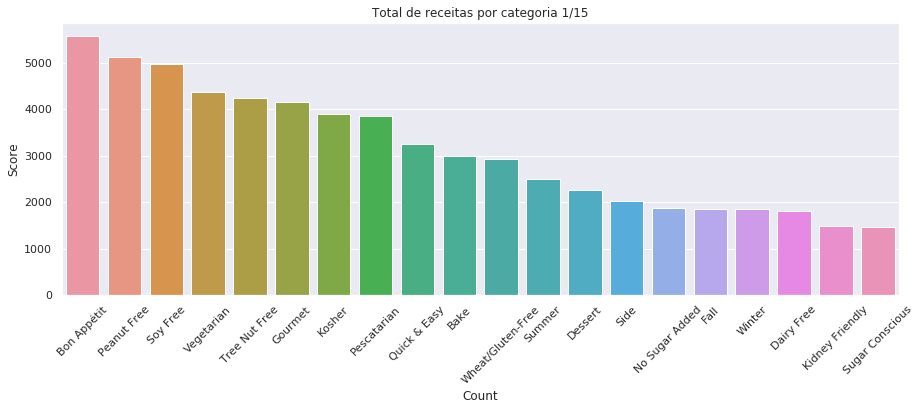

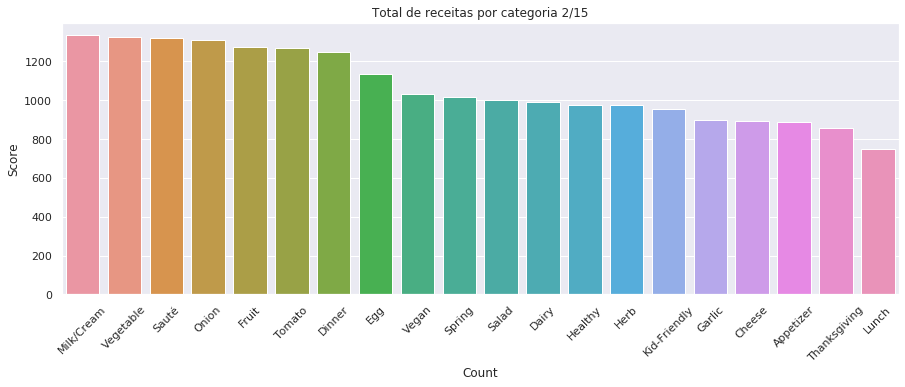

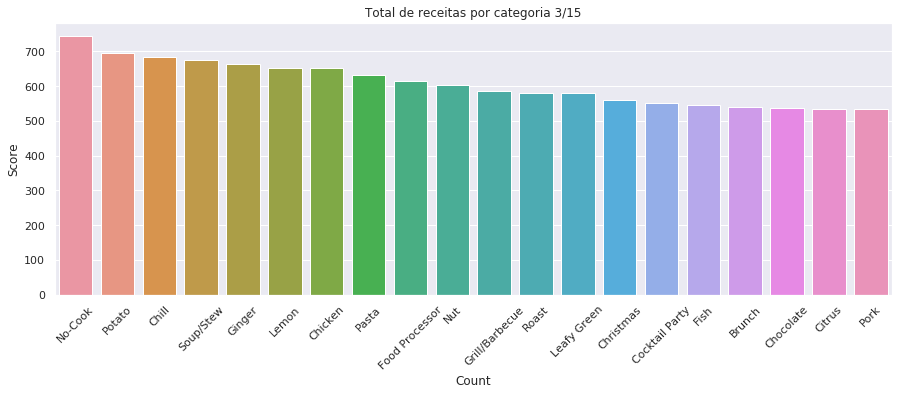

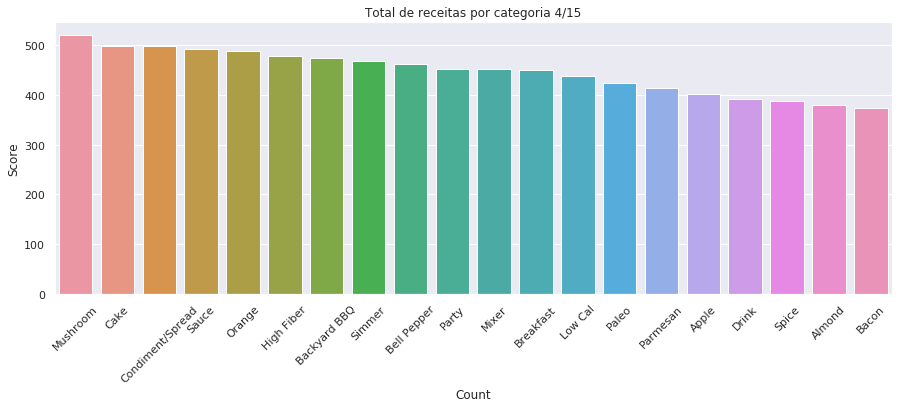

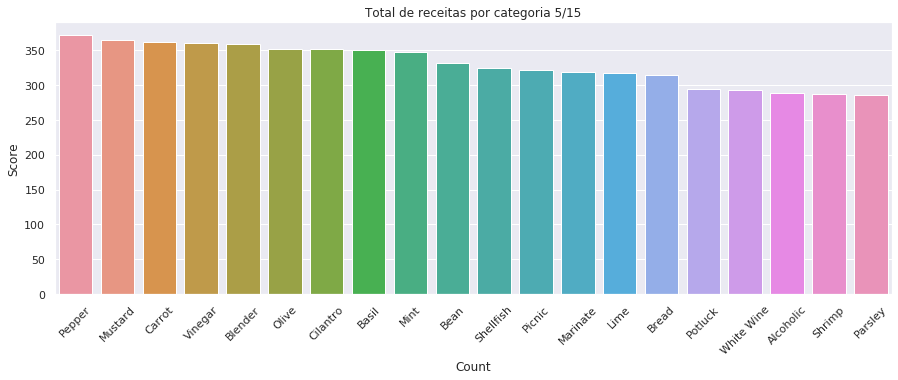

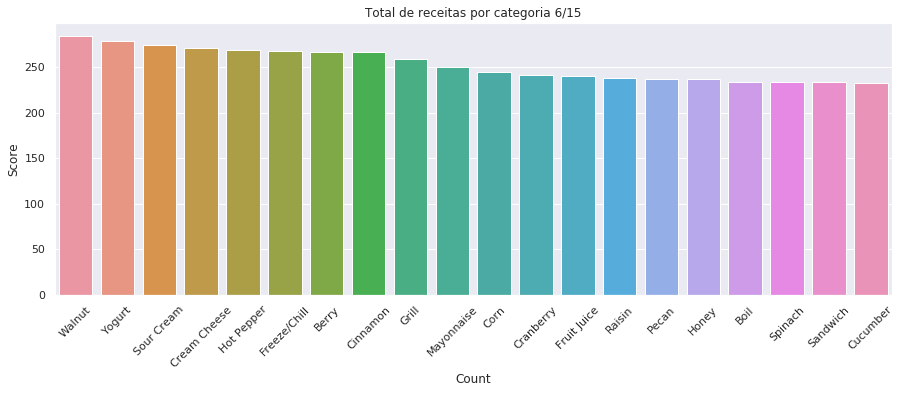

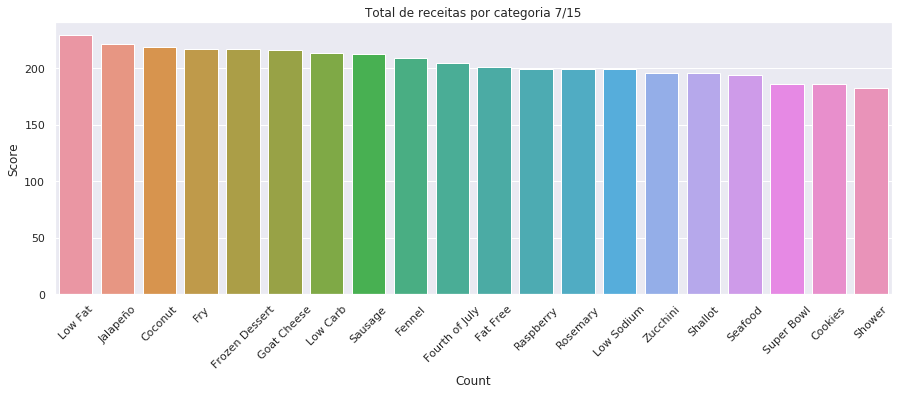

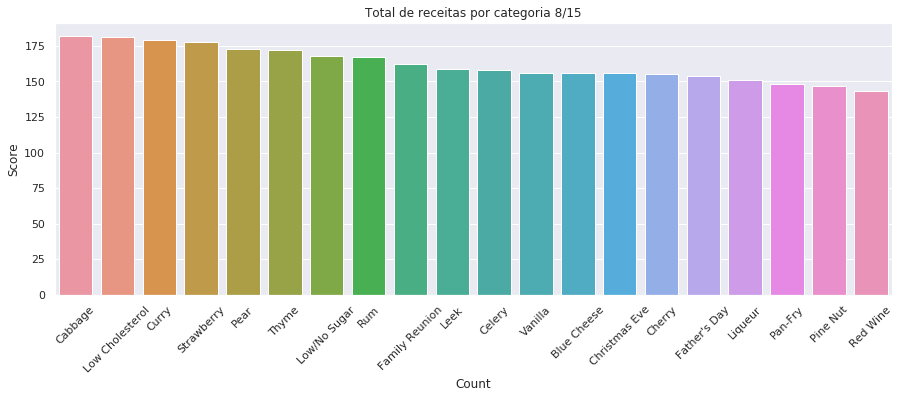

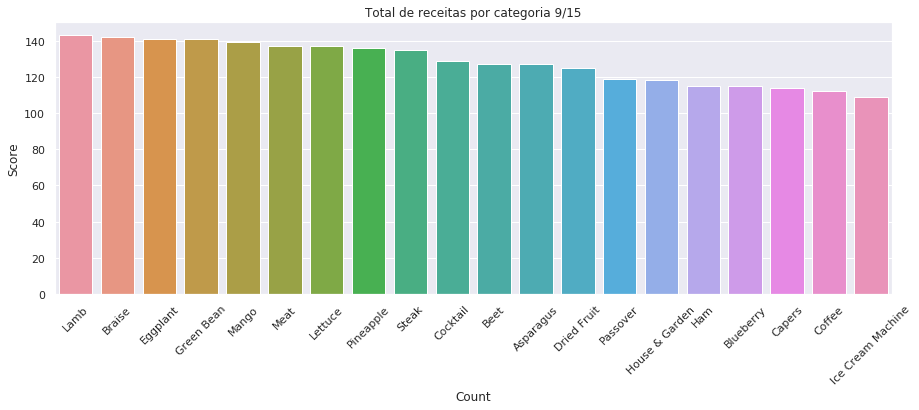

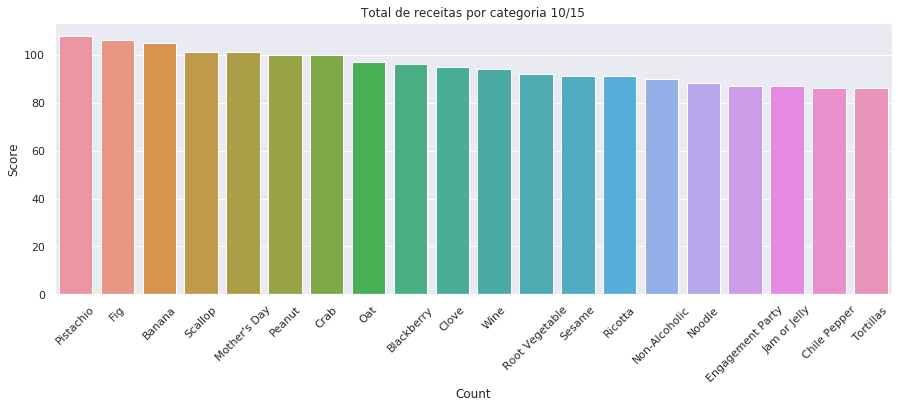

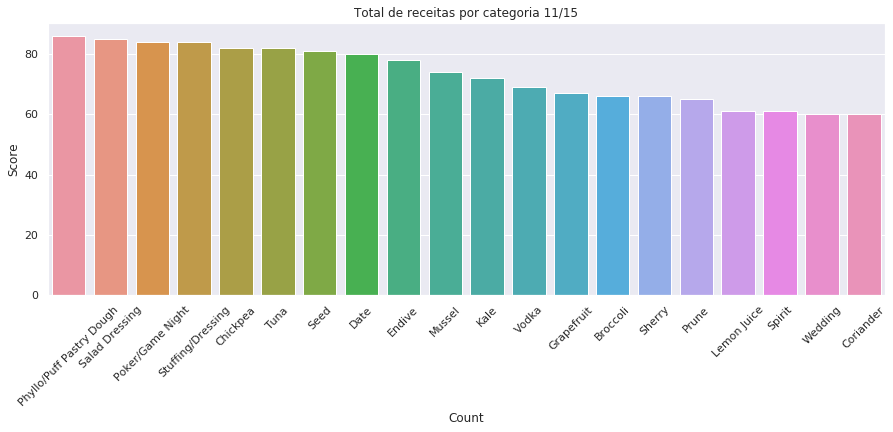

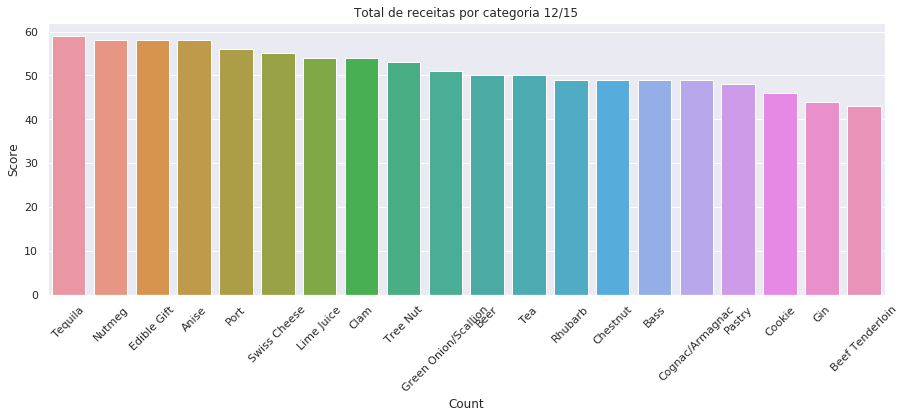

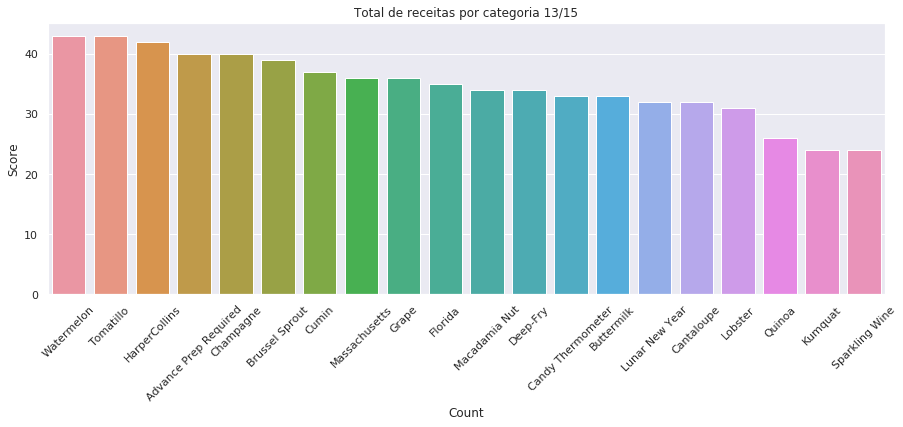

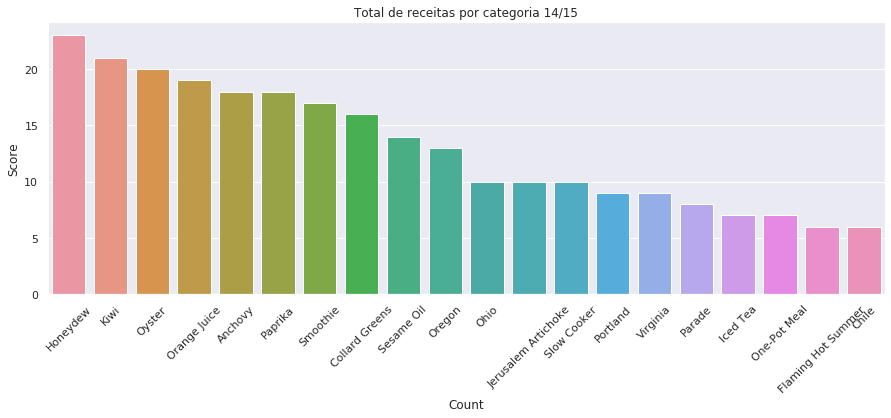

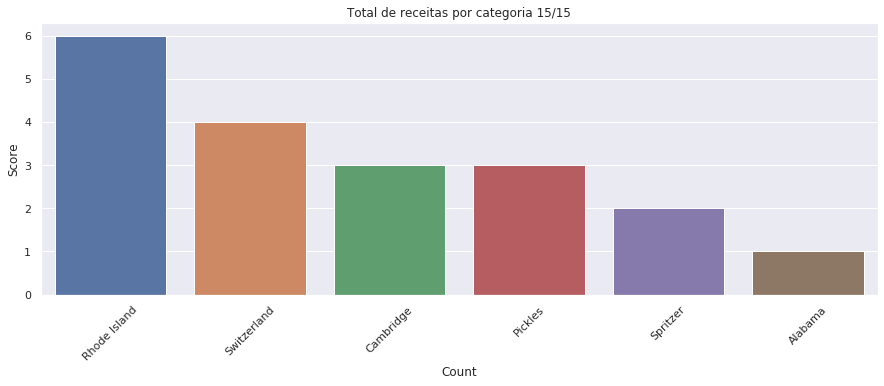

In [45]:
total_recipes = df_features.sort_values(['rating'], ascending=False)[:100].iloc[:, 1528:].sum().sort_values(ascending=False)
total_recipes = total_recipes[total_recipes > 0].reset_index().drop(columns=[0])
list_categories = list(total_recipes['index'])
df_categories = df_features[list_categories].sum().sort_values(ascending=False)
df_categories = df_categories.reset_index().rename(columns={0: 'count'})

for i in range(math.ceil(len(df_categories) / 20)):
    plt.figure(figsize=(15, 5))
    categories_graph = sns.barplot(data=df_categories[20 * i: 20 * (i + 1)].reset_index(), x='index', y='count')
    categories_graph.set_xticklabels(categories_graph.get_xticklabels(), rotation=45)
    categories_graph.set_title(f'Total de receitas por categoria {i + 1}/{math.ceil(len(df_categories) / 20)}')
    categories_graph.set_xlabel('Count')
    categories_graph.set_ylabel('Score')

### Os gráficos acima foram divididos em partes, mas eles exibem a mesma informação. As 286 categorias mostradas nos gráficos são as que definem as 100 receitas mais bem avaliadas. Cada uma dessas categorias, define o número de receitas exibido no eixo y.

## 2.6. [opcional] Construa um classificador para recomendar tags (categorias) para as receitas

### Como todos os preparativos para o classificador já foram feitos anteriormente, só nos resta fazer as escolhas estratégicas.

### Esse é um problema de classificação multilabel, isto é, o classificador deve classificar cada instância como sendo pertencente a nenhuma ou várias categorias. Uma instância poderia até pertencer a todas as categorias, em teoria. Uma estratégia bastante adotada no treinamento de classificadores multilabel, é a utilização do OneVsRest. O OneVsRest consiste numa série de classificadores, um para cada label. Normalmente são utilizados com SVMs, para fazer a separação das classes. Para o nosso problema em específico, a útilização da loss function L1 é mais apropriada, por se tratar de um dataset relativamente grande.

In [46]:
clf = OneVsRestClassifier(LinearSVC(penalty='l1', dual=False, max_iter=10000))
scaler = MinMaxScaler()
X = df_features.iloc[:, :1528].to_numpy()
X = scaler.fit_transform(X)
y = df_features.iloc[:, 1528:].astype(float).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
    
clf.fit(X_train, y_train)
print('Training finished!')

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 400 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 437 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 503 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 507 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 517 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 581 is present in all training examples.
  str(classes[c]))
/home/bruno/anaconda3/lib/python3.7/site-packa

Training finished!


In [47]:
def multilabel_score(target, input_, classifier):
    output = classifier.predict(input_)
    result = abs(target - output)
    acc = []
    for i in range(len(result)):
        instance_acc = []
        for j in range(result.shape[1]):
            instance_acc.append(result[i, j])
            if j + 1 == result.shape[1]:
                acc.append(1 - np.mean(instance_acc))
    return np.mean(acc)

train_acc = multilabel_score(y_train, X_train, clf)
print(f'A acurácia do treinamento foi: {train_acc:.4f}')

test_acc = multilabel_score(y_test, X_test, clf)
print(f'A acurácia do teste foi:       {test_acc:.4f}')

A acurácia do treinamento foi: 0.9913
A acurácia do teste foi:       0.9864


### A função acima foi elaborada para calcular a acurácia da classificação multilabel. A acurácia implementada no Scikit Learn não é apropriada para este tipo de classificação, visto que, caso uma instância não acertasse 100% das 636 labels existentes, ele atribuiria uma acurácia de 0% naquela instância, o que eventualmente atribuiria uma acurácia de 0% ao modelo no fim do treinamento/teste. Com esse problema em mente, elaborei a função "multilabel_score" para dar uma pontuação proporcional aos acertos. Se ao fim do treinamento/teste todas as instâncias acertassem metade das labels disponíveis, sua acurácia atribuída seria de 50%.
### O nosso modelo obteve uma acurácia bastante alta, tanto em treinamento, quanto em validação. Isso significa que ele tem uma boa capacidade de predizer categorias para receitas que ele nunca viu, bastando ter acesso às informações necessárias.

# 3. Considerações finais
### Acredito que os exercícios propostos foram respondidos e foi um desafio interessante proposto. Obrigado por ler até aqui e estou disponível para quaisquer esclarecimentos. Obrigado!